## **[Week 9] Classification**

In this practice session, we will cover the following:
- Look over the MNIST dataset
- Revisit softmax function and Multi-Layer Perceptrons (MLP)
- Train a linear model for classification on the MNIST dataset
- Train a multi-layer perceptron (MLP) for classification on the MNIST dataset

**[Important]** \\
The results of the exercises should be included in your weekly report for this practice session.
The weekly report for this session should be submitted to KLMS by this weekend. No late submission would be accepted.

### 1. Preparations

First, we need to import the required packages

In [ ]:
# Import packages
import torch                                    # PyTorch (an open-source machine-learning library for Python)
import torch.nn as nn                           # Building blocks in PyTorch
import torch.nn.functional as F                 # Functionals in PyTorch
import torch.optim as optim                     # Optimization methods implemented in PyTorch
import numpy as np                              # Tool for mathematical and scientific computations
import random                                   # Generating pesudo-random numbers
import time                                     # Time access
from torch.utils.data import DataLoader         # Wrapper for the easy use of dataset samples
from torchvision import datasets, transforms    # Access to pre-loaded datasets
from matplotlib import pyplot as plt            # Tool for plot and visualization

Let's select the device to use.

- If using a GPU, then the device will be 'cuda'.
- If not using a GPU, then the device will be 'cpu'.

If you want to check whether GPU is available or not, use `torch.cuda.is_available()`.

In [ ]:
# Set PyTorch device (use GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# If GPU is available, check CUDA version
if torch.cuda.is_available():
    !nvcc --version

cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


The following code fixes the random seed of pseudo-random generators.

Numbers made by pseudo-random generators are determined by their seeds, so different seeds will result in different outcomes.

In [ ]:
# Set random seeds fixed for reproducibility
seed = 7    # Do NOT change the seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

### 2. MNIST Dataset

In this section, we will look into the **MNIST (Modified National Institute of Standards and Technology database)** dataset.

#### 2-1. About MNIST

MNIST is a database of hand-written digits consisting of 60,000 samples for training and 10,000 samples for evaluation.

The input and output of each sample is the following:
- Input: a gray-scale image of size 28x28, we flattened the image into a one-dimensional vector of size 784(=28x28).
    - Each element ranges from 0 (black) to 1 (white).
- Output: a scalar label(class) indicating the digit (0-9). There are ten classes (0-9).

The objective is to train the model to predict the digit from the input.

The figure below shows some MNIST samples in the dataset.

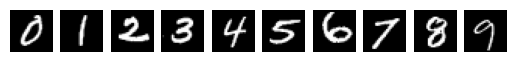

In [ ]:
from IPython.display import Image
Image("figures/mnist_sample.png", width=1000)

#### 2-2. Define MNIST datasets and dataloaders

To train a model using MNIST, we have to define the datasets and dataloaders.

``torch.datasets`` package provides several pre-loaded datasets, including MNIST.

Commonly used datasets fall into three categories:
- **Training dataset** is used to train the model.
- **Validation dataset** is used to evaluate the performance of the trained model for fine-tuning the model's hyperparameters.
    - The validation dataset is usually a part of the training dataset but not used for training. Tuning hyperparameters based on test accuracy will make the model overfit to the test dataset. We want the model to generalize to unseen data.
- **Test dataset** is used to evaluate the final performance of the trained model.

``Dataloader`` enables us to easily generate the mini-batches of (input, output) pairs from the datasets for each training iteration.

In [ ]:
# MNIST Datasets
mnist_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

# Dataloaders
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=128, shuffle=True, drop_last=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=128, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 123683860.37it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 5496923.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39110175.23it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21821911.53it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Let's visualize some more MNIST samples.

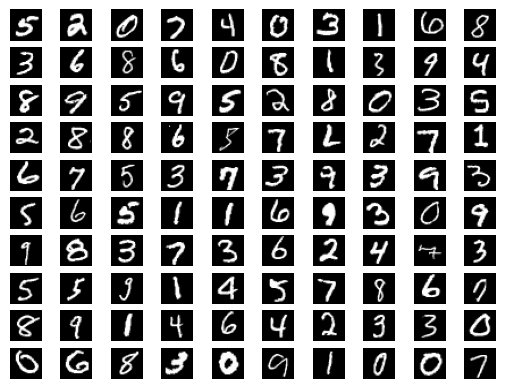

In [ ]:
# Visualize MNIST samples
for i in range(100):
    index = random.randint(0, 50000)
    x_sample, _ = mnist_train[index]
    plt.subplot(10, 10, i+1)
    plt.imshow(x_sample[0], cmap='gray')
    plt.axis('off')

#### 2-3. Flattening the inputs

In this practice session, the original inputs are two-dimensional, but the model takes one-dimensional inputs.

In this case, we reshape the input into a one-dimensional vector.

We use ``torch.reshape()`` to reshape tensors.

In [ ]:
# Check size of an input sample
x_sample, _ = mnist_train[0]
print(x_sample.shape)       # torch.Size([1, 28, 28]). 1 is the batch size and 28 is the width and height of the input image.

# Reshape the two-dimensional input (x_sample) into one-dimensional vector (x_flat_sample)
_, width, height = x_sample.shape
x_flat_sample = x_sample.reshape(-1, width * height)
print(x_flat_sample.shape)  # torch.Size([1, 784]). 1 is the batch size and 784 is the length of the input vector.

torch.Size([1, 28, 28])
torch.Size([1, 784])


***Note.*** When referring to the dimension of the input, it is customary to exclude the batch size from the input's dimension count.

### 3. Multinomial Classification via a Linear Model with Softmax

In this section, we will construct a linear model with softmax for multinomial classification on the MNIST dataset.

#### 3-1. Softmax function

Let's recall the softmax function. Softmax function maps a set of real values into a set of values ranging from 0 to 1.

Let $z_1, \cdots, z_C$ be the input values. The output of the softmax function is the values $p_1, \cdots, p_C$, where the $i$th value $p_i$ is defined by

\begin{align}
    p_i
    = \text{softmax}(z_1, \cdots, z_C)_i
    = \dfrac{\exp(z_i)}{\sum_{j=1}^C \exp(z_j)}
\end{align}

Note that $p_i \geq 0$ for $i=1, \cdots, C$ and $\sum_{i=1}^C p_i = 1$. Therefore, the softmax function is widely used to convert real values into discrete probabilities, where a higher number leads to a higher probability.

##### ***Note.*** Log-Sum-Exp Trick

When implementing the softmax function, the Log-Sum-Exp trick is usually used for numerical stability.

\begin{align}
    \text{softmax}(z_1, \cdots, z_C)_i
    &= \exp \bigg( \log \bigg( \dfrac{\exp(z_i)}{\sum_{j=1}^C \exp(z_j)} \bigg) \bigg) \\
    &= \exp \bigg( z_i - \log \bigg( \sum_{j=1}^C \exp(z_j) \bigg) \bigg) \\
    &= \exp \bigg( z_i - \text{logsumexp}(z_1, \cdots, z_C) \bigg) \bigg)
\end{align}
where $\text{logsumexp}(z_1, \cdots, z_C) = \log ( \sum_{j=1}^C \exp(z_j))$

The following code shows the implementation of the softmax function. Try each option and see the difference in the output.

In [ ]:
# Softmax function
def softmax(x):
    # return torch.exp(x) / torch.sum(torch.exp(x))                     # (1) You can try this first. This will show wrong output for Example 2.
    # return torch.softmax(x, dim=-1)                                   # (2) This is the softmax function in PyTorch.
    return torch.exp(x - torch.logsumexp(x, dim=-1, keepdim=True))    # (3) This is equivalent to torch.softmax(x, dim=-1).

# ==================================================
"""
For Exaples 1 and 2,
- the softmax output should be tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
                                       [0.0117, 0.0317, 0.0861, 0.2341, 0.6364]])
- the output of the softmax should be tensor([1.0000, 1.0000])
"""


# ==================================================
# Example 1
z1 = torch.Tensor([[-2, -1, 0, 1, 2],
                   [1, 0, -2, 0, 1]])
p1 = softmax(z1)

print("z1 = ")
print(z1)
print()
print("softmax(z1) = ")
print(p1)
print()
print("sum of softmax(z1) = {}".format(torch.sum(p1, axis=-1)))
print()

# ==================================================
# Example 2
z2 = torch.Tensor([[998, 999, 1000, 1001, 1002],
                   [-1002, -1001, -1000, -999, -998]])
p2 = softmax(z2)

print("z2 = ")
print(z2)
print()
print("softmax(z2) = ")
print(p2)
print()
print("sum of softmax(z2) = {}".format(torch.sum(p2, axis=-1)))

z1 = 
tensor([[-2., -1.,  0.,  1.,  2.],
        [ 1.,  0., -2.,  0.,  1.]])

softmax(z1) = 
tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.3590, 0.1321, 0.0179, 0.1321, 0.3590]])

sum of softmax(z1) = tensor([1., 1.])

z2 = 
tensor([[  998.,   999.,  1000.,  1001.,  1002.],
        [-1002., -1001., -1000.,  -999.,  -998.]])

softmax(z2) = 
tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.0117, 0.0317, 0.0861, 0.2341, 0.6364]])

sum of softmax(z2) = tensor([1.0000, 1.0000])


#### 3-2. A Linear Layer with Softmax Function

In this section, we will use a linear layer (also called a fully-connected layer).

Let $\mathbf{x} \in \mathbb{R}^n$ be an input. Let $n$ and $m$ be the dimension of the input and output, respectively.

The linear layer consists of a weight matrix $\mathbf{W} \in \mathbb{R}^{m \times n}$ and a bias vector $\mathbf{b} \in \mathbb{R}^m$.

The output of the linear layer is $\mathbf{z} = \mathbf{W} \mathbf{x} + \mathbf{b} \in \mathbb{R}^m$.

The softmax function is applied to the output of the linear layer $\mathbf{z} = z_1, \cdots, z_C$, which outputs the probabilities $p_1, \cdots, p_C$.

The output of the final layer $z_1, \cdots, z_C$ is often called as ***logits***.

This term is originated from the logit function. The logit function is the inverse of the sigmoid function, and the sigmoid function is a specialized version of the softmax function.

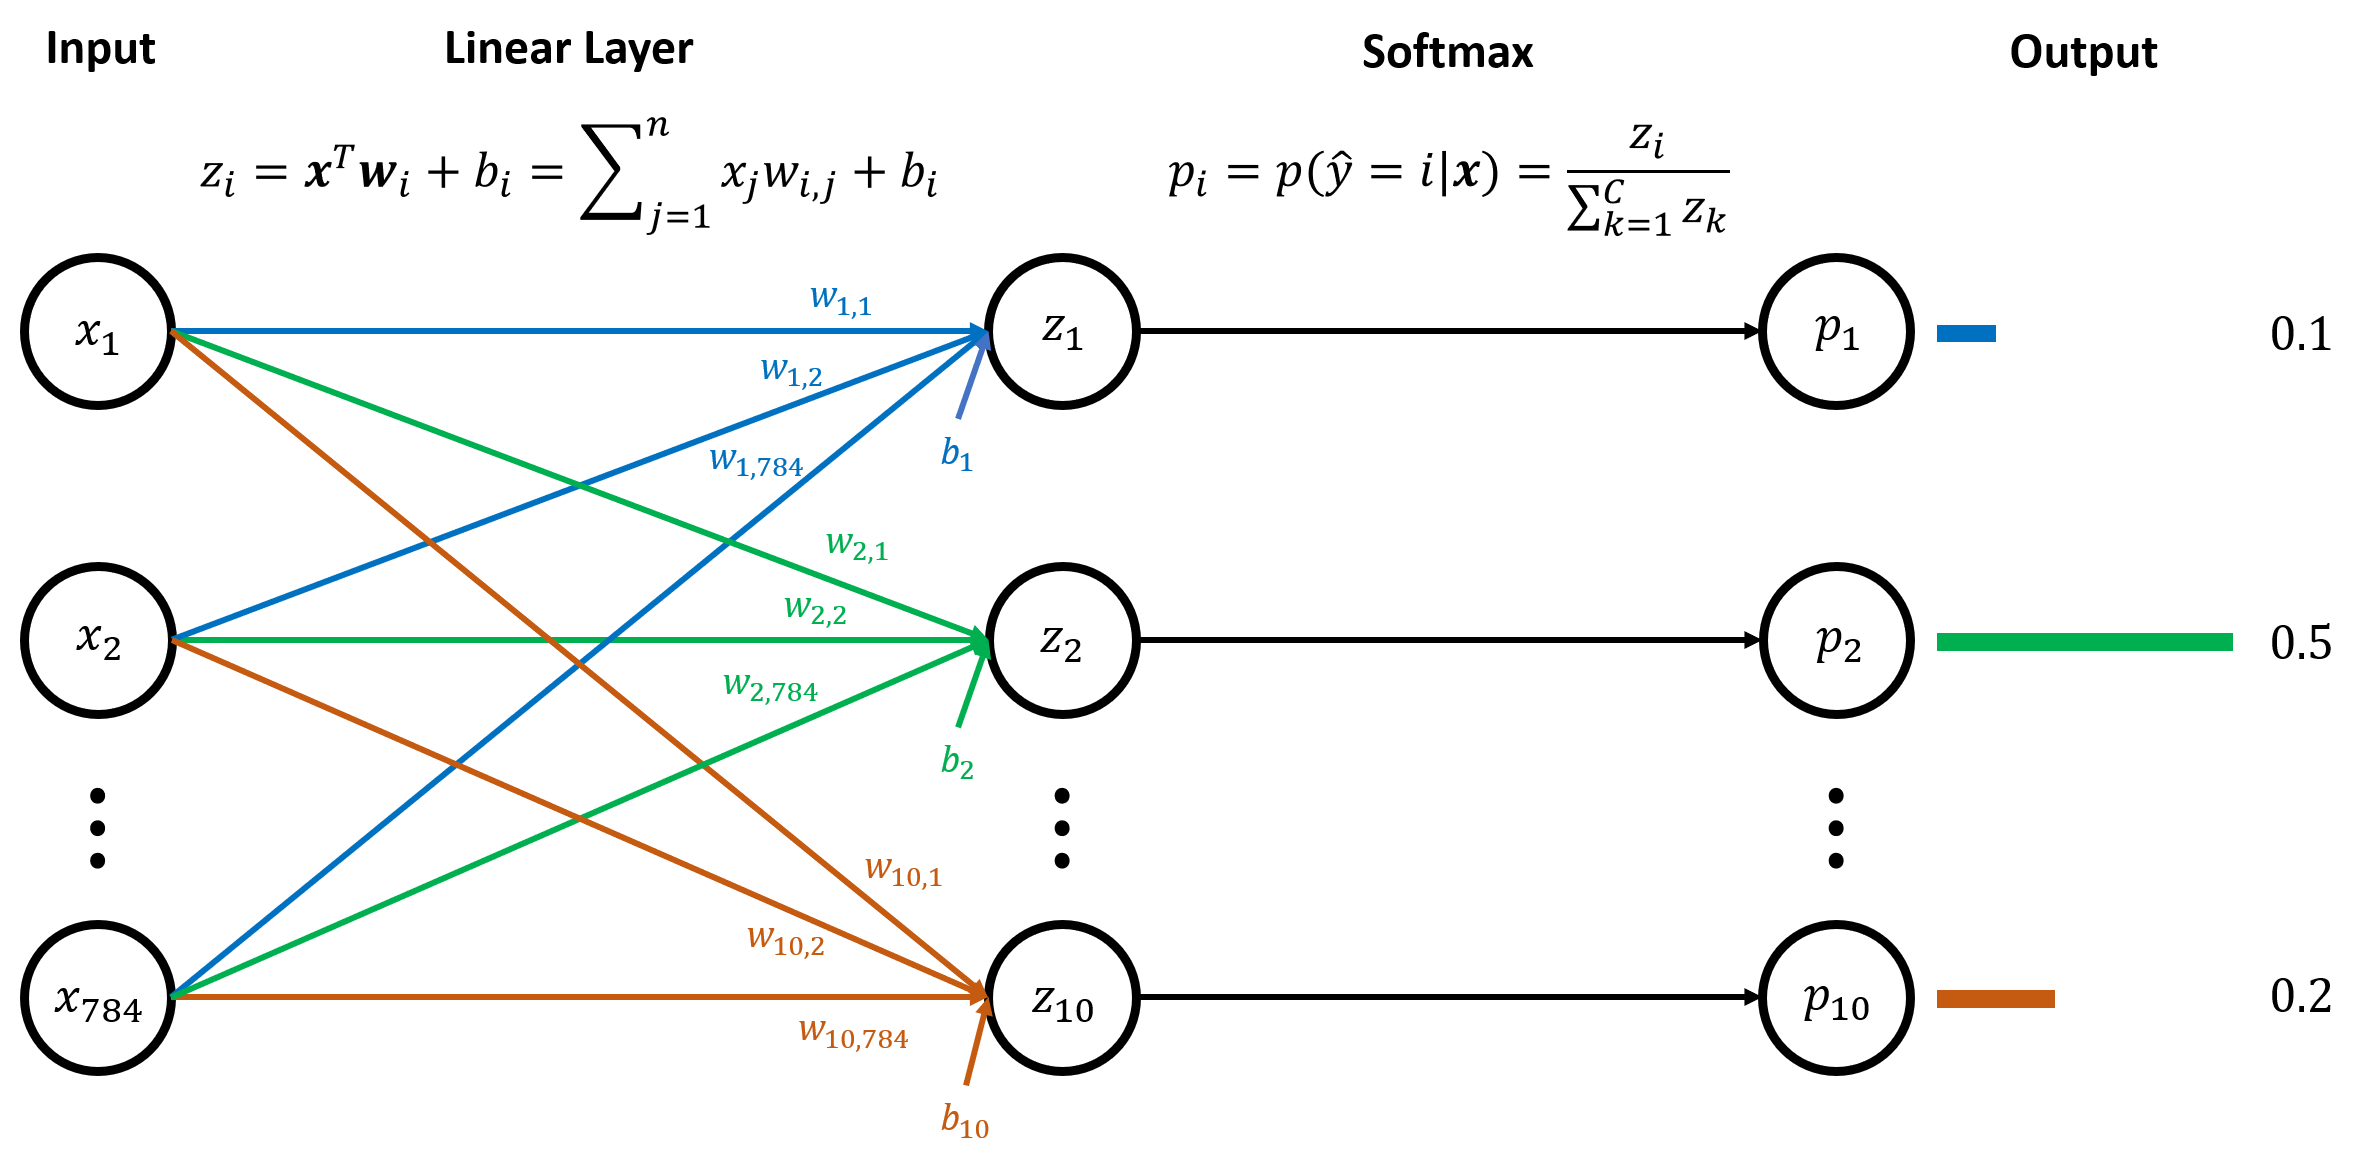

In [ ]:
from IPython.display import Image
Image("figures/linear_layer_softmax.png", width=1000)

Let's see how to create a linear layer and define the forward process of the linear layer.

``nn.Linear`` creates a linear layer.

In [ ]:
# Define a linear layer and feed an input to the linear layer
x = torch.randn([784])          # Input
linear = nn.Linear(784, 10)     # Linear layer nn.Linear(in_features=784, out_features=10)
z = linear(x)                   # Output

# Print information
print(linear)                   # Layer info.
print()
print("Weight")
print(linear.weight)            # Weight matrix (W)
print(linear.weight.shape)
print()
print("Bias")
print(linear.bias)              # Bias vector (b)
print(linear.bias.shape)
print()
print("Output")
print(z)
print(z.shape)                  # torch.Size([10])


Linear(in_features=784, out_features=10, bias=True)

Weight
Parameter containing:
tensor([[-0.0221,  0.0334, -0.0301,  ..., -0.0141,  0.0209,  0.0282],
        [ 0.0303,  0.0026, -0.0313,  ..., -0.0304, -0.0044, -0.0268],
        [-0.0177,  0.0121,  0.0328,  ...,  0.0319,  0.0080, -0.0226],
        ...,
        [-0.0102, -0.0160,  0.0097,  ...,  0.0204, -0.0139, -0.0314],
        [ 0.0201,  0.0032,  0.0271,  ...,  0.0217, -0.0333, -0.0050],
        [ 0.0118,  0.0116,  0.0084,  ..., -0.0184, -0.0241, -0.0209]],
       requires_grad=True)
torch.Size([10, 784])

Bias
Parameter containing:
tensor([ 0.0063, -0.0146,  0.0119,  0.0055, -0.0176, -0.0206, -0.0034,  0.0324,
        -0.0101, -0.0198], requires_grad=True)
torch.Size([10])

Output
tensor([-0.7257, -0.1519, -0.0179,  0.2221,  0.3707,  0.8961, -0.1385,  0.6305,
        -0.3098,  1.1594], grad_fn=<ViewBackward0>)
torch.Size([10])


#### 3-3. Define a linear classification model

Now we define a linear classification model. This model consists of one linear layer ``linear``.

**Exercise 1.** Implement ``linear`` and implement the forward process of the model.

In [ ]:
# Define a model
class LinearClassificationModel(nn.Module):
    def __init__(self, input_unit, output_unit):
        # input_unit: the number of input units (= input size)
        # output_unit: the number of output units (= the number of classes)
        super(LinearClassificationModel, self).__init__()

        """ ### Implement the code yourself ### """

        self.linear = nn.Linear(input_unit, output_unit)

        """ ################################### """

    def forward(self, x):

        """ ### Implement the code yourself ### """

        out = self.linear(x)

        """ ################################### """

        return out

model = LinearClassificationModel(input_unit=784, output_unit=10).to(device)

#### 3-4. Define a loss function

We will use cross-entropy as a loss function.

Let $p_i$ be the predicted probability for class $i$ ($i=1, \cdots, C$) given an input $\mathbf{x}$, and let $y_i$ be the true label.

The cross-entropy loss ($\mathcal{L}_{CE}(\mathbf{x})$) for input $\mathbf{x}$ is

\begin{align}
    \mathcal{L}_{CE}(\mathbf{x}) = -\sum_{i=1}^C y_i \log p_i
\end{align}

where
\begin{align}
    p_i=p(\hat{y} = i | \mathbf{x}) = \dfrac{\exp(z_i)}{\sum_{j=1}^C \exp(z_j)}
\end{align}

and $z_i = \mathbf{x}^T \mathbf{w}_i + b_i$ is the $i$th element of the output of the model.

The following code is an example of implementing the cross-entropy loss function.

In [ ]:
# Implementation of the cross-entropy loss function

# PyTorch cross-entropy loss function
cross_entropy_torch = nn.CrossEntropyLoss()

# Softmax function
def softmax(x):
    return torch.softmax(x, dim=-1)

# Manual cross-entropy loss function
def cross_entropy_manual(input, target):
    prob = softmax(input)
    cross_entropy_loss = -torch.mean(torch.log(prob[range(target.shape[0]), target]))
    return cross_entropy_loss

z = torch.Tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [7, 6, 5, 4, 3, 2, 1, 0, 1, 2],
    [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001]
    ]
)           # Logits
y = torch.Tensor([
    0,
    3,
    7,
    9]
).long()    # True Label

# The two outputs should be the same
print(cross_entropy_torch(z, y))
print(cross_entropy_manual(z, y))

tensor(3.1723)
tensor(3.1723)


When training the model, we use ``nn.CrossEntropyLoss()`` for a loss function.

However, the ``cross_entropy_manual`` function implemented above is equivalent to ``nn.CrossEntropyLoss()``.

In [ ]:
# Define a loss function
loss_function = nn.CrossEntropyLoss()

#### 3-5. Define an optimizer

We will use Stochastic Gradient Descent (SGD) as an optimization method.

In [ ]:
# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### 3-6. Train the classifier

Now we are ready to train the classifier.

If you want to train the model again from scratch, start from Section 3.3.

In [ ]:
# Train the classifier
total_train_epochs = 20             # The number of training epochs

x_sample, _ = mnist_train[0]        # To reshaping input
_, width, height = x_sample.shape   # To reshaping input

start_time = time.time()            # To measure wall-clock time for training
average_loss_list_linear = []       # To record average training losses

# Training loop
for epoch in range(total_train_epochs):
    average_loss = 0.0
    steps = 0

    # Each iteration
    for n, data in enumerate(dataloaders['train'], 0):
        x, y_true = data                                    # x = input, y_true = label
        x_flat = x.reshape(-1, width * height).to(device)   # Flattening the input
        y_true = y_true.to(device)
        y_pred = model(x_flat)                              # y_pred = output of the model
        loss = loss_function(input=y_pred, target=y_true)   # Compute loss

        optimizer.zero_grad()                               # Delete previously computed gradients
        loss.backward()                                     # Compute the gradients by backpropagation
        optimizer.step()                                    # Update the parameters of the model using the gradients

        average_loss += loss.item()
        steps += 1

    # Print average loss
    print("Epoch: {:3d} | Iter: {:3d} | Average Loss: {:5.3f} | Elapsed Time: {:6.1f} s".format(
        epoch + 1, n+1, average_loss / steps, time.time()-start_time)
    )
    average_loss_list_linear.append(average_loss / steps)
    average_loss = 0.0
    steps = 0

    # Validation (examine the accuracy after each training epoch)
    total = 0
    correct = 0
    model.eval()                                            # Evaluation mode (no training)
    with torch.no_grad():                                   # No gradient computation
        for data in dataloaders['val']:
            x, y_true = data
            x_flat = x.reshape(-1, width * height).to(device)
            y_true = y_true.to(device)
            y_pred = model(x_flat)
            loss = loss_function(input=y_pred, target=y_true)
            y_pred_argmax = torch.max(y_pred, dim=1)        # y_pred_argmax = predicted label. Choose the index with the highest output value.

            total += y_true.size(0)                                     # total number of prediction
            correct += (y_pred_argmax.indices == y_true).sum().item()   # correct prediction
    model.train()                                           # Training mode

    # Print validation accuracy
    print('Epoch: {:3d} | Validation Accuracy: {:5.3f} %'.format(epoch + 1, correct / total * 100))
    print()

Epoch:   1 | Iter: 390 | Average Loss: 1.355 | Elapsed Time:    8.8 s
Epoch:   1 | Validation Accuracy: 82.970 %

Epoch:   2 | Iter: 390 | Average Loss: 0.761 | Elapsed Time:   15.1 s
Epoch:   2 | Validation Accuracy: 85.300 %

Epoch:   3 | Iter: 390 | Average Loss: 0.620 | Elapsed Time:   21.8 s
Epoch:   3 | Validation Accuracy: 86.390 %

Epoch:   4 | Iter: 390 | Average Loss: 0.552 | Elapsed Time:   29.3 s
Epoch:   4 | Validation Accuracy: 87.110 %

Epoch:   5 | Iter: 390 | Average Loss: 0.510 | Elapsed Time:   35.7 s
Epoch:   5 | Validation Accuracy: 87.560 %

Epoch:   6 | Iter: 390 | Average Loss: 0.482 | Elapsed Time:   42.5 s
Epoch:   6 | Validation Accuracy: 87.920 %

Epoch:   7 | Iter: 390 | Average Loss: 0.461 | Elapsed Time:   48.7 s
Epoch:   7 | Validation Accuracy: 88.200 %

Epoch:   8 | Iter: 390 | Average Loss: 0.445 | Elapsed Time:   55.8 s
Epoch:   8 | Validation Accuracy: 88.540 %

Epoch:   9 | Iter: 390 | Average Loss: 0.432 | Elapsed Time:   62.6 s
Epoch:   9 | Valid

#### 3-7. Test the trained classifier

Let's evaluate the trained model on the test dataset.

In [ ]:
# Test the model
total = 0
correct = 0

model.eval()
with torch.no_grad():                                   # No gradient computation
    for data in dataloaders['test']:
        x, y_true = data
        x_flat = x.reshape(-1, width * height).to(device)
        y_true = y_true.to(device)
        y_pred = model(x_flat)
        loss = loss_function(input=y_pred, target=y_true)
        y_pred_argmax = torch.max(y_pred, dim=1)        # y_pred_argmax = predicted label. Choose the index with the highest output value.

        total += y_true.size(0)                                     # total number of prediction
        correct += (y_pred_argmax.indices == y_true).sum().item()   # correct prediction

# Print test accuracy
print('Test Accuracy: {:5.3f} %'.format(correct / total * 100))

Test Accuracy: 90.630 %


### 4. Classification via Multi-Layer Perceptrons (MLP)

In this section, we will train a multi-layer model for classification on the MNIST dataset.

Unlike linear models, multi-layer models have one or more hidden layers with a non-linear activation function after each hidden layer.

The hidden layers with non-linear activations enable the model to express complex non-linearities.

The figure below illustrates the process of a hidden layer.

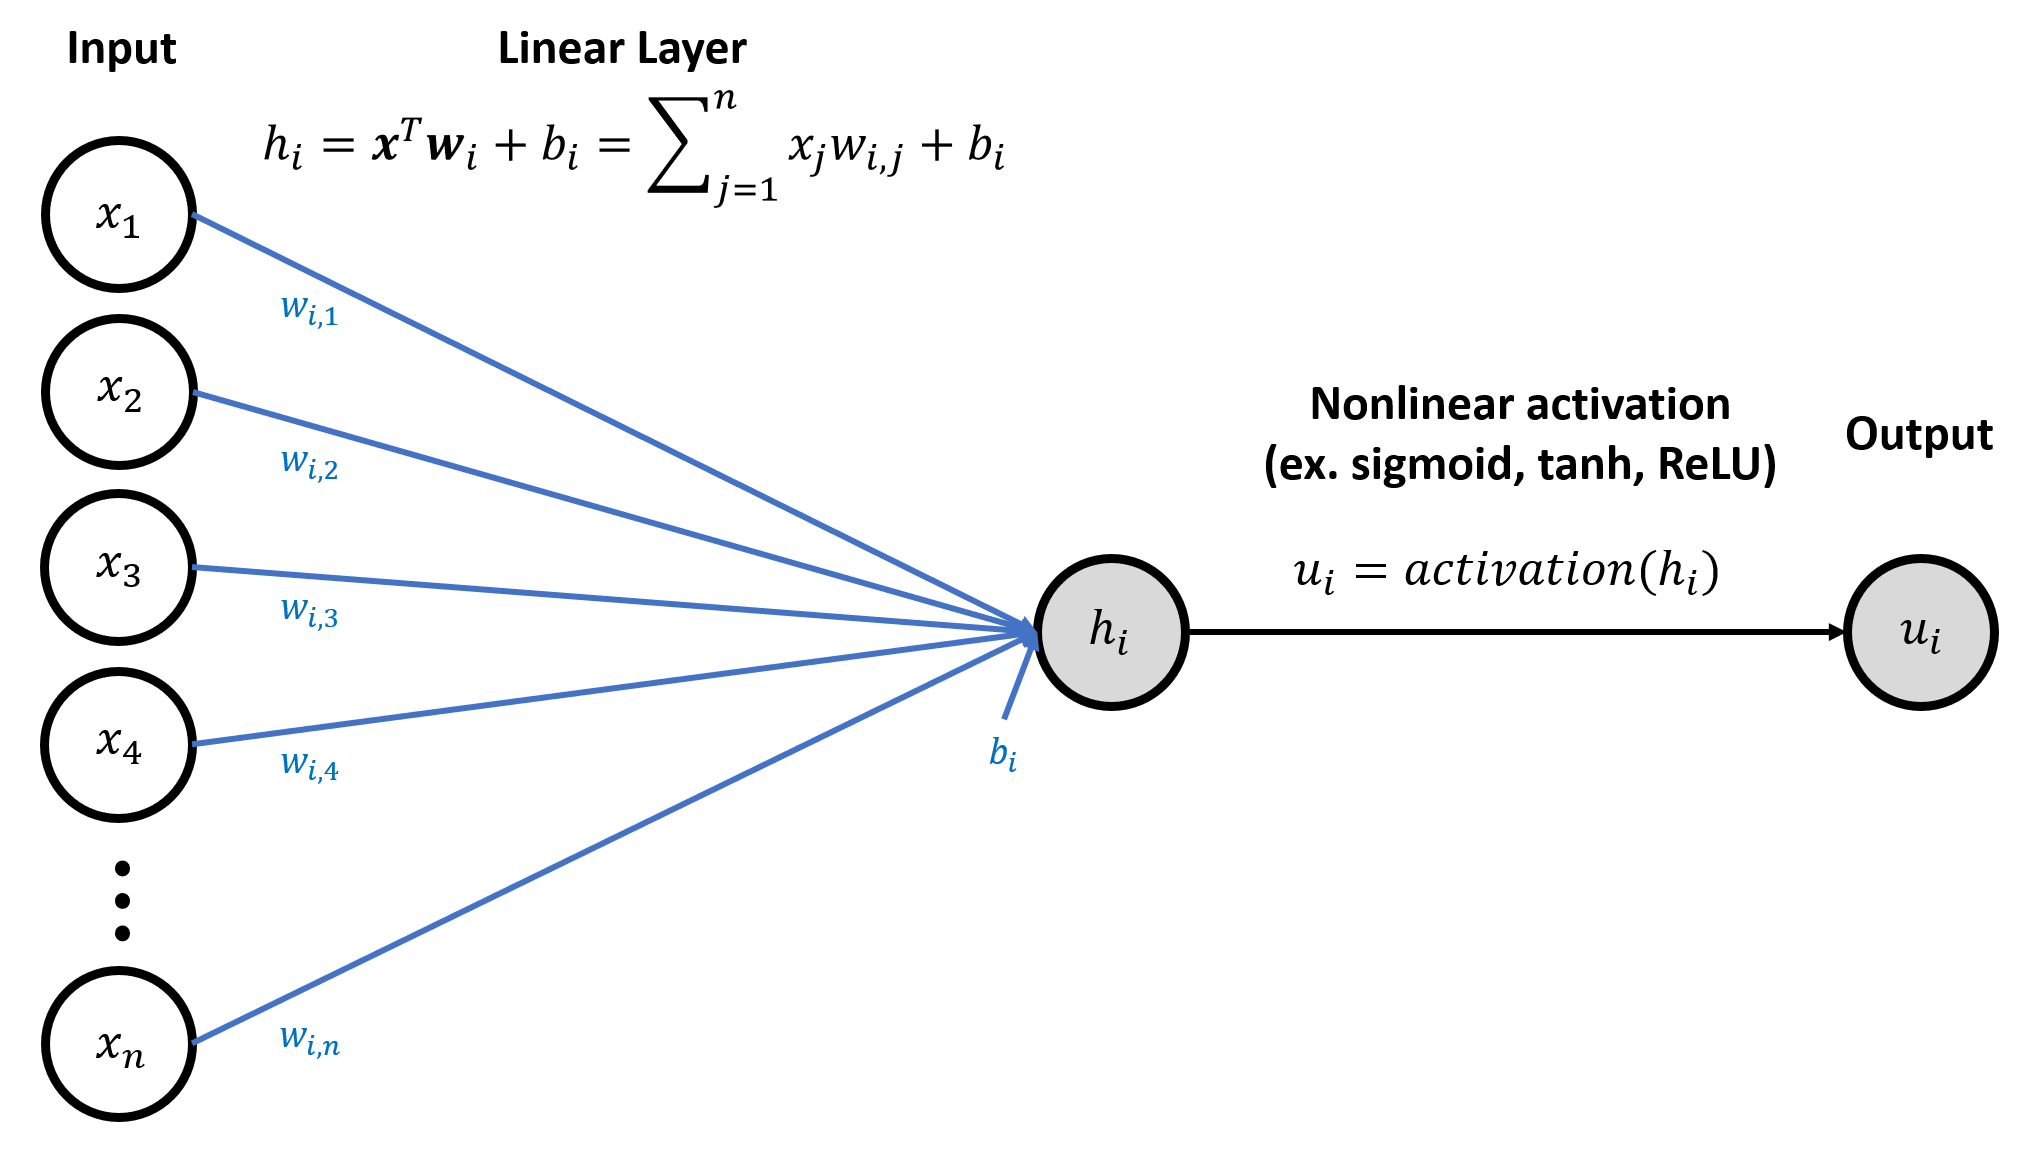

In [ ]:
from IPython.display import Image
Image("figures/hidden_unit.png", width=1000)

#### 4-1. Activation functions

The following code is an example of using non-linear activations. Some examples of activations are the following:
- Sigmoid: $\text{sigmoid}(x) = \frac{1}{1+e^{-x}}$. We use ``nn.Sigmoid()`` as an implementation.
- Tangent hyperbolic (Tanh): $\text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$. We use ``nn.Tanh()`` as an implementation.
- Rectified Linear Unit (ReLU): $\text{ReLU}(x) = \max\{0, x\}$. We use ``nn.ReLU()`` as an implementation.

**Exercise 2.** Implement the sigmoid, tanh, and ReLU functions yourself using the mathematical definition of each function.

In [ ]:
# Activation functions
x = torch.Tensor([[-2, -1, 0, 1, 2]])          # Input

# PyTorch Implementation
torch_sigmoid = nn.Sigmoid()    # Sigmoid
torch_tanh = nn.Tanh()          # Tanh
torch_relu = nn.ReLU()          # ReLU

# Manual Implementation
""" ### Implement the code yourself ### """
z_sigmoid = 1/(1+torch.exp(-x))                                              # Hint: use torch.exp()
z_tanh = (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))           # Hint: use torch.exp()
z_relu = torch.maximum(torch.zeros_like(x), x)                               # Hint: use torch.zeros_like() and torch.maximum()
""" ################################### """

# PyTorch Implementation
y_sigmoid = torch_sigmoid(x)
y_tanh = torch_tanh(x)
y_relu = torch_relu(x)

print("x:")
print(x)
print()

print("sigmoid(x):")     # "z_sigmoid" should be equal to "y_sigmoid"
print("PyTorch implementation: {}".format(z_sigmoid))
print("Manual implementation : {}".format(y_sigmoid))
print()

print("tanh(x):")        # "z_tanh" should be equal to "y_tanh"
print("PyTorch implementation: {}".format(z_tanh))
print("Manual implementation : {}".format(y_tanh))
print()

print("ReLU(x):")        # "z_relu" should be equal to "y_relu"
print("PyTorch implementation: {}".format(z_relu))
print("Manual implementation : {}".format(y_relu))


x:
tensor([[-2., -1.,  0.,  1.,  2.]])

sigmoid(x):
PyTorch implementation: tensor([[0.1192, 0.2689, 0.5000, 0.7311, 0.8808]])
Manual implementation : tensor([[0.1192, 0.2689, 0.5000, 0.7311, 0.8808]])

tanh(x):
PyTorch implementation: tensor([[-0.9640, -0.7616,  0.0000,  0.7616,  0.9640]])
Manual implementation : tensor([[-0.9640, -0.7616,  0.0000,  0.7616,  0.9640]])

ReLU(x):
PyTorch implementation: tensor([[0., 0., 0., 1., 2.]])
Manual implementation : tensor([[0., 0., 0., 1., 2.]])


The figure below illustrates an example structure of a multi-layer model.

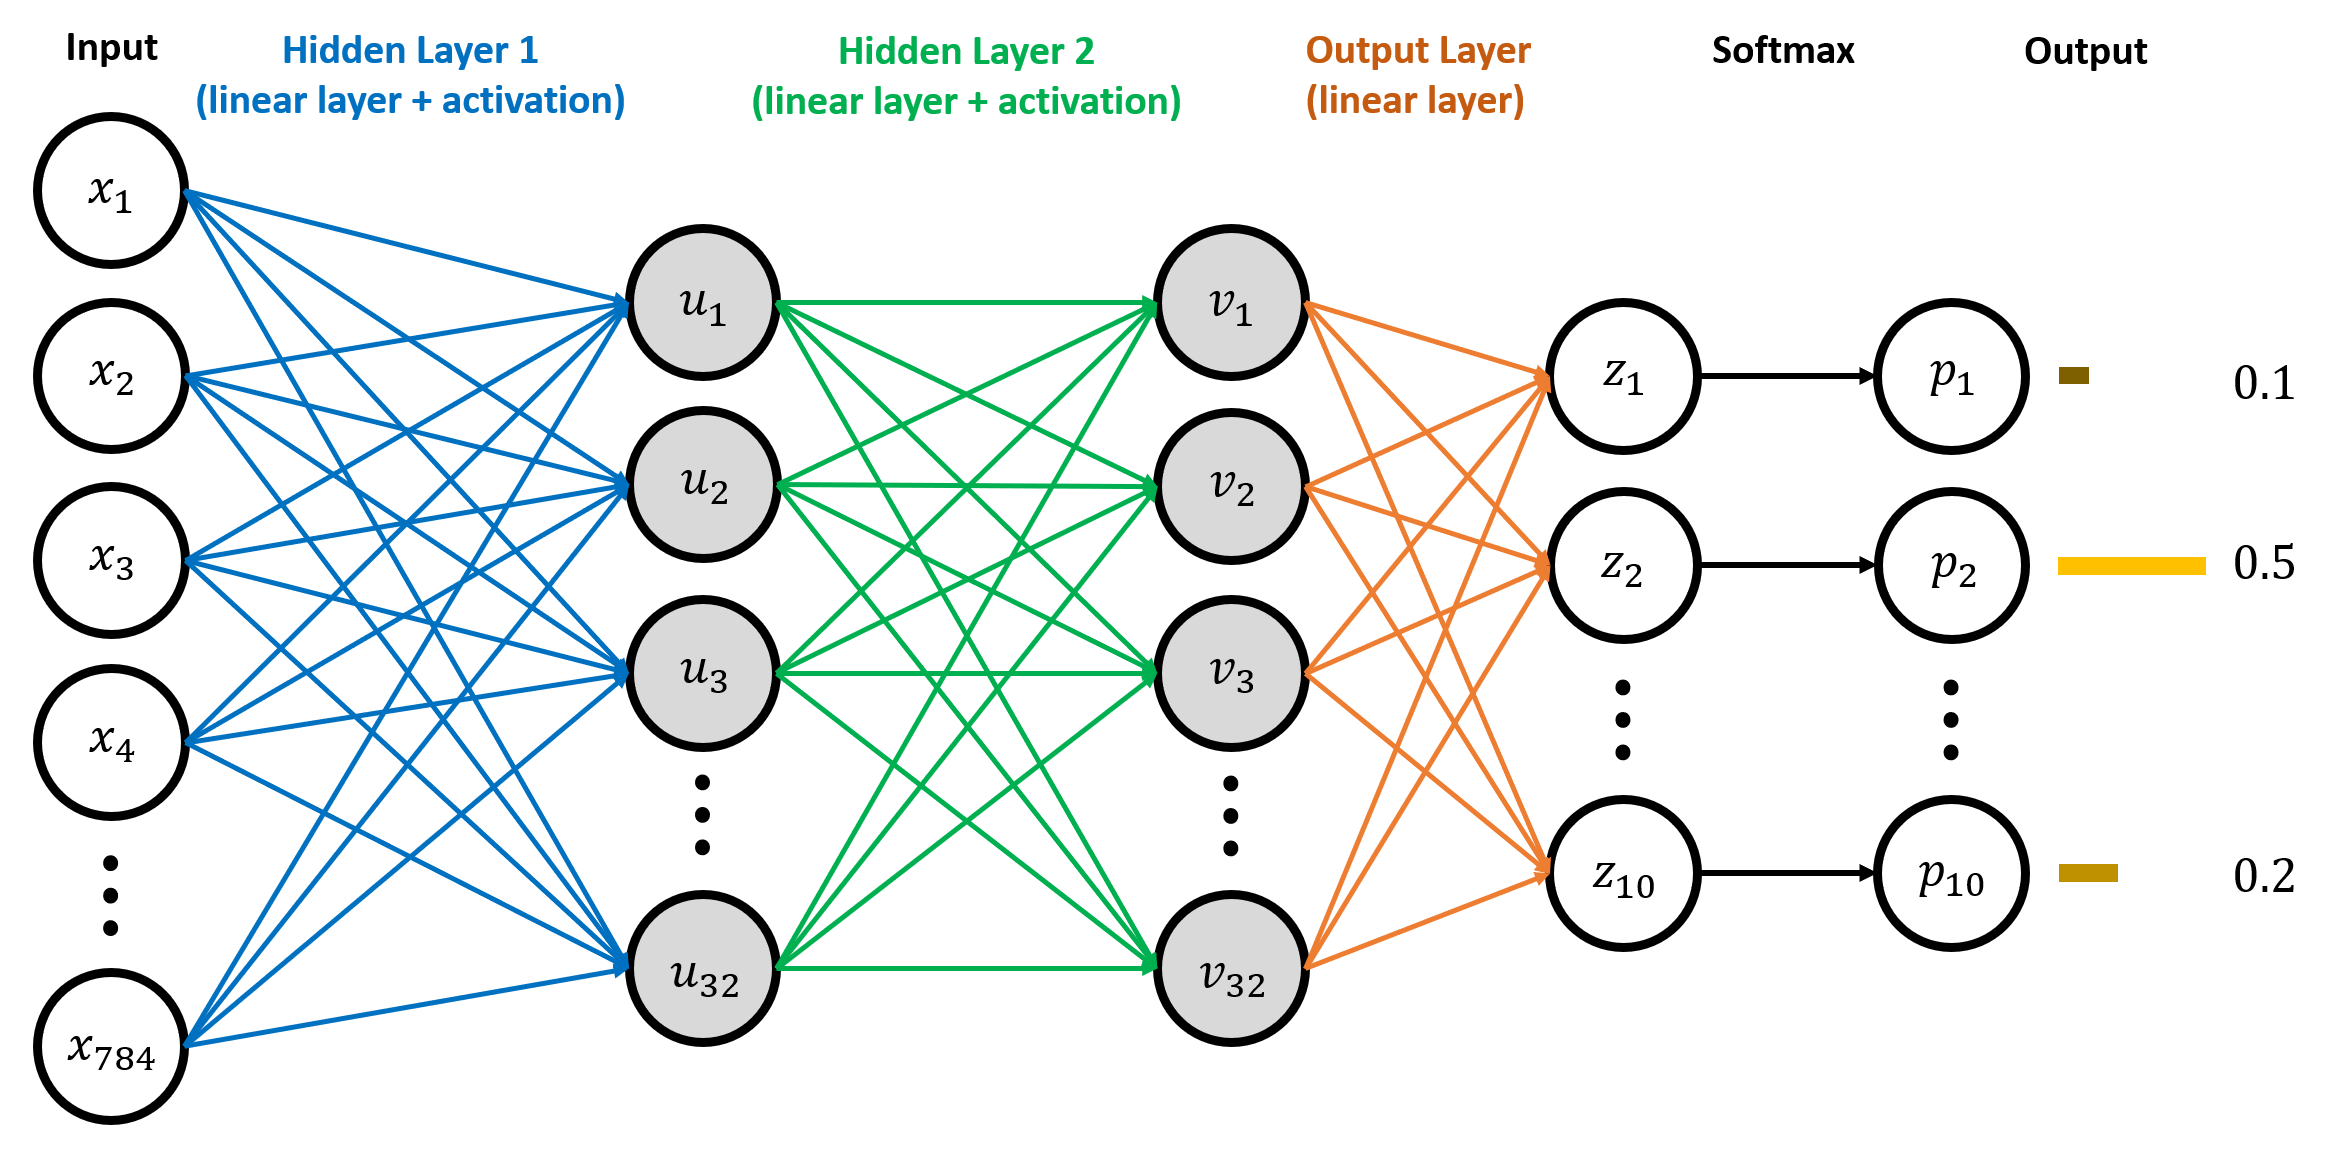

In [ ]:
from IPython.display import Image
Image("figures/mlp.png", width=1000)

#### 4-2. Define a multi-layer classification model

Now we define an MLP classification model. This model consists of two hidden layers ``fc1``, and ``fc2`` with activations (we use ReLU activation) and a linear layer ``fc3`` without activations.

**Exercise 3.** Implement ``fc1``, ``fc2``, and ``fc3``. Also, implement the forward process of the model.

In [ ]:
# Define a model
class MultiLayerClassificationModel(nn.Module):
    def __init__(self, input_unit, hidden_unit, output_unit):
        # input_unit: the number of input units (= input size)
        # hidden_unit: the number of hidden units
        # output_unit: the number of output units (= the number of classes)
        super(MultiLayerClassificationModel, self).__init__()

        """ ### Implement the code yourself ### """

        self.fc1 = nn.Linear(input_unit, hidden_unit)               # fully-connected layer 1
        self.fc2 = nn.Linear(hidden_unit, hidden_unit)                 # fully-connected layer 2
        self.fc3 = nn.Linear(hidden_unit, output_unit)                 # fully-connected layer 3

        """ ################################### """

        # self.activ = nn.Sigmoid()
        # self.activ = nn.Tanh()
        self.activ = nn.ReLU()

    def forward(self, x):

        """ ### Implement the code yourself ### """

        full1 = self.fc1(x)                                       # fully-connected layer 1
        act1 = self.activ(full1)                                  # activation
        full2 = self.fc2(act1)                                    # fully-connected layer 2
        act2 = self.activ(full2)                                  # activation
        out = self.fc3(act2)                                      # fully-connected layer 3
        """ ################################### """

        return out

model = MultiLayerClassificationModel(input_unit=784, hidden_unit=32, output_unit=10).to(device)

#### 4-3. Define a loss function

Same as in the previous section, we will use cross-entropy as a loss function.

In [ ]:
# Define a loss function
loss_function = nn.CrossEntropyLoss()

#### 4-4. Define an optimizer

Same as in the previous section, we will use Stochastic Gradient Descent (SGD) as an optimization method.

In [ ]:
# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### 4-5. Train the classifier

Now we are ready to train the classifier. The training loop is the same as that in the previous section.

If you want to train the model again from scratch, start from Section 4.1.

In [ ]:
# Train the classifier
total_train_epochs = 20             # The number of training epochs

x_sample, _ = mnist_train[0]        # To reshaping input
_, width, height = x_sample.shape   # To reshaping input

start_time = time.time()            # To measure wall-clock time for training
average_loss_list_mlp = []          # To record average training losses

# Training loop
for epoch in range(total_train_epochs):
    average_loss = 0.0
    steps = 0

    # Each iteration
    for n, data in enumerate(dataloaders['train'], 0):
        x, y_true = data                                    # x = input, y_true = label
        x_flat = x.reshape(-1, width * height).to(device)   # Flattening the input
        y_true = y_true.to(device)
        y_pred = model(x_flat)                              # y_pred = output of the model
        loss = loss_function(input=y_pred, target=y_true)   # Compute loss

        optimizer.zero_grad()                               # Delete previously computed gradients
        loss.backward()                                     # Compute the gradients by backpropagation
        optimizer.step()                                    # Update the parameters of the model using the gradients

        average_loss += loss.item()
        steps += 1

    # Print average loss
    print("Epoch: {:3d} | Iter: {:3d} | Average Loss: {:5.3f} | Elapsed Time: {:6.1f} s".format(
        epoch + 1, n+1, average_loss / steps, time.time()-start_time)
    )
    average_loss_list_mlp.append(average_loss / steps)
    average_loss = 0.0
    steps = 0

    # Validation (examine the accuracy after each training epoch)
    total = 0
    correct = 0
    model.eval()                                            # Evaluation mode (no training)
    with torch.no_grad():                                   # No gradient computation
        for data in dataloaders['val']:
            x, y_true = data
            x_flat = x.reshape(-1, width * height).to(device)
            y_true = y_true.to(device)
            y_pred = model(x_flat)
            loss = loss_function(input=y_pred, target=y_true)
            y_pred_argmax = torch.max(y_pred, dim=1)        # y_pred_argmax = predicted label. Choose the index with the highest output value.

            total += y_true.size(0)                                     # total number of prediction
            correct += (y_pred_argmax.indices == y_true).sum().item()   # correct prediction
    model.train()                                           # Training mode

    # Print validation accuracy
    print('Epoch: {:3d} | Validation Accuracy: {:5.3f} %'.format(epoch + 1, correct / total * 100))
    print()

Epoch:   1 | Iter: 390 | Average Loss: 2.214 | Elapsed Time:    5.5 s
Epoch:   1 | Validation Accuracy: 31.150 %

Epoch:   2 | Iter: 390 | Average Loss: 1.700 | Elapsed Time:   12.8 s
Epoch:   2 | Validation Accuracy: 74.960 %

Epoch:   3 | Iter: 390 | Average Loss: 0.925 | Elapsed Time:   19.5 s
Epoch:   3 | Validation Accuracy: 83.460 %

Epoch:   4 | Iter: 390 | Average Loss: 0.593 | Elapsed Time:   26.7 s
Epoch:   4 | Validation Accuracy: 86.650 %

Epoch:   5 | Iter: 390 | Average Loss: 0.473 | Elapsed Time:   34.1 s
Epoch:   5 | Validation Accuracy: 87.660 %

Epoch:   6 | Iter: 390 | Average Loss: 0.419 | Elapsed Time:   41.0 s
Epoch:   6 | Validation Accuracy: 88.590 %

Epoch:   7 | Iter: 390 | Average Loss: 0.387 | Elapsed Time:   48.3 s
Epoch:   7 | Validation Accuracy: 89.260 %

Epoch:   8 | Iter: 390 | Average Loss: 0.365 | Elapsed Time:   54.8 s
Epoch:   8 | Validation Accuracy: 89.360 %

Epoch:   9 | Iter: 390 | Average Loss: 0.349 | Elapsed Time:   62.1 s
Epoch:   9 | Valid

#### 4-6. Test the trained classifier

Let's evaluate the trained model on the test dataset.

In [ ]:
# Test the model
total = 0
correct = 0

model.eval()
with torch.no_grad():                                   # No gradeint computation
    for data in dataloaders['test']:
        x, y_true = data
        x_flat = x.reshape(-1, width * height).to(device)
        y_true = y_true.to(device)
        y_pred = model(x_flat)
        loss = loss_function(input=y_pred, target=y_true)
        y_pred_argmax = torch.max(y_pred, dim=1)        # y_pred_argmax = predicted label. Choose the index with the highest output value.

        total += y_true.size(0)                                     # total number of prediction
        correct += (y_pred_argmax.indices == y_true).sum().item()   # correct prediction

# Print test accuracy
print('Test Accuracy: {:5.3f} %'.format(correct / total * 100))

Test Accuracy: 92.650 %


#### 4-7. Comparing training losses

Let's plot the training loss for each epoch of the linear classifier and MLP classifier.

Can you see the difference in the losses and test accuracies between a linear classifier and a MLP classifier?

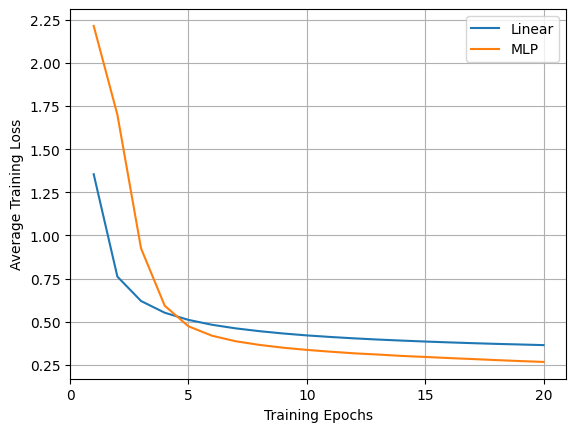

In [ ]:
# Plot training loss for each epoch
epoch_list = [i+1 for i in range(20)]
plt.plot(epoch_list, average_loss_list_linear, label='Linear')
plt.plot(epoch_list, average_loss_list_mlp, label='MLP')
plt.xlabel('Training Epochs')
plt.ylabel('Average Training Loss')
plt.xticks([0, 5, 10 ,15, 20])
plt.grid(visible=True)
plt.legend()

## References

- https://cs231n.github.io/linear-classify/
- https://pytorch.org/tutorials/beginner/basics/intro.html
- https://github.com/deeplearningzerotoall/PyTorch/blob/master/lab-09_4_mnist_nn_deep.ipynb